# [Sutton and Barto Notebooks](https://github.com/seungjaeryanlee/sutton-barto-notebooks): Figure 6.5

Author: Ryan Lee  
저자: 이승재  

This notebook is an implementation of Figure 6.5 in [Sutton and Barto's Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book-2nd.html).  
이 노트북은 [Sutton and Barto의 Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book-2nd.html) 책의 Figure 6.5를 구현한 결과입니다.

![Figure 6.5](figure_6_5.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def argmax_all(list_):
    """
    Returns all argmax of given list in a list. Different from np.argmax which returns first instance only.
    주어진 list의 최대값들의 index들을 list 형태로 반환합니다. 첫 최대값의 index만 반환하는 np.argmax와는 다릅니다.
    """
    return np.argwhere(list_ == np.max(list_)).flatten().tolist()

In [3]:
from enum import IntEnum
class Action(IntEnum):
    """
    Actions possible in state A.
    상태 A에서 선택 가능한 행동들.
    """
    LEFT = 0
    RIGHT = 1

In [4]:
class Environment:
    """
    Simple two-armed bandit environment shown in Sutton and Barto Figure 6.5.
    Sutton and Barto Figure 6.5의 환경입니다.
    """
    NUMBER_OF_ACTIONS = 10 # Number of actions possible in state B

    def __init__(self):
        self.state = 'A'

    def action_space(self):
        """
        Return all possible actions for the current state.
        현재 상태에서의 가능한 모든 행동을 반환합니다.
        """
        if self.state == 'A':
            return [Action.LEFT, Action.RIGHT]
        elif self.state == 'B':
            return range(self.NUMBER_OF_ACTIONS)
        else:
            return []

    def is_terminal(self):
        """
        Check is the current state is terminal.
        현재 상태가 끝 상태인지 확인합니다.
        """
        return self.state == 'X'

    def reset(self):
        """
        Reset environment and return initial state.
        환경을 초기화하고 첫 상태를 반환합니다.
        """
        self.state = 'A'
        return self.state

    def step(self, action):
        """
        Take a given action and return tuple (next_state, reward, done).
        주어진 행동을 취하고 (다음 상태, 보상, 에피소드가 끝남)를 반환합니다.
        """
        if self.state == 'A' and action == Action.LEFT:
            self.state = 'B'
            return ('B', 0, False)
        elif self.state == 'A' and action == Action.RIGHT:
            self.state = 'X'
            return ('X', 0, True)
        else:
            self.state = 'X'
            return ('X', np.random.normal(-0.1, 1), True)

In [5]:
class QLearningAgent:
    epsilon = 0.1
    learning_rate = 0.1
    discount_factor = 1

    def __init__(self, env):
        """
        Initialize Q table and save environment.
        Q 테이블을 초기화하고 주어진 환경을 보관합니다.
        """
        self.q_table = {
            'A': [0, 0],
            'B': [0] * env.NUMBER_OF_ACTIONS
        }
        self.env = env

    def get_action(self, state):
        """
        Returns action based on Q table and epsilon-greedy policy.
        엡실론 탐욕 정책과 Q테이블을 이용해 주어진 상태에서 할 행동을 반환합니다.
        """
        best_actions = argmax_all(self.q_table[state])

        if np.random.choice(['e', '1-e'], p=[self.epsilon, 1 - self.epsilon]) == 'e':
            return np.random.choice(self.env.action_space())
        else:
            return np.random.choice(best_actions)

    def update_q(self, state, action, reward, next_state, done):
        """
        Update Q table via Q-learning.
        Q러닝을 통해 Q 테이블을 업데이트합니다.
        """
        if done:
            target = reward
        else:
            target = reward + self.discount_factor * np.max(self.q_table[next_state])

        self.q_table[state][action] = (1 - self.learning_rate) * self.q_table[state][action] + self.learning_rate * target

In [6]:
class DoubleQLearningAgent:
    epsilon = 0.1
    learning_rate = 0.1
    discount_factor = 1

    def __init__(self, env):
        """
        Initialize Q table and save environment.
        Q 테이블을 초기화하고 주어진 환경을 보관합니다.
        """
        self.q1 = {'A': [0, 0], 'B': [0] * env.NUMBER_OF_ACTIONS}
        self.q2 = {'A': [0, 0], 'B': [0] * env.NUMBER_OF_ACTIONS}
        self.q_table = [self.q1, self.q2]
        self.env = env

    def get_action(self, state):
        """
        Returns action based on Q table and epsilon-greedy policy.
        엡실론 탐욕 정책과 Q테이블을 이용해 주어진 상태에서 할 행동을 반환합니다.
        """
        q_state = np.add(self.q1[state], self.q2[state])
        best_actions = argmax_all(q_state)

        if np.random.choice(['e', '1-e'], p=[self.epsilon, 1 - self.epsilon]) == 'e':
            return np.random.choice(self.env.action_space())
        else:
            return np.random.choice(best_actions)

    def update_q(self, state, action, reward, next_state, done):
        """
        Update Q table via Double Q-learning.
        더블 Q러닝을 통해 Q 테이블을 업데이트합니다.
        """
        if done:
            target = reward
        else:
            target = reward + self.discount_factor * self.q2[next_state][np.argmax(self.q1[next_state])]
        
        if np.random.choice(['q1', 'q2']) == 'q1':
            self.q1[state][action] = (1 - self.learning_rate) * self.q1[state][action] + self.learning_rate * target
        else:
            self.q2[state][action] = (1 - self.learning_rate) * self.q2[state][action] + self.learning_rate * target

In [7]:
def run_episode(Agent):
    """
    Creates an agent with given Agent class and runs one episode. (Only for debugging)
    주어진 Agent 클래스로 에이전트를 만들어서 에피소드를 1번 실행합니다. (디버깅 전용)
    """
    env = Environment()
    agent = Agent(env)

    state = env.reset()
    action = agent.get_action(state)
    next_state, reward, done = env.step(action)

    print('State      : ', state)
    print('Action     : ', action)
    print('Reward     : ', reward)
    print('Next State : ', next_state)

    agent.update_q(state, action, reward, next_state, done)
    print(agent.q_table)

    if not done:
        state = next_state
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        print('State      : ', state)
        print('Action     : ', action)
        print('Reward     : ', reward)
        print('Next State : ', next_state)

        agent.update_q(state, action, reward, next_state, done)
        print(agent.q_table)

In [8]:
run_episode(DoubleQLearningAgent)

State      :  A
Action     :  1
Reward     :  0
Next State :  X
[{'A': [0, 0], 'B': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}, {'A': [0, 0.0], 'B': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}]


In [9]:
def run_trials(n_trials, n_episodes, Agent, Environment):
    """
    Runs `n_trials` trials on given Agent and Environment. For each trial,
    `n_episodes` episodes are run, and Q table is reset after each trial.
    주어진 Agent와 Environment 클래스를 활용해서 트라이얼을 n_trial번 실행합니다. 각
    트라이얼마다 에피소드를 n_episode번 실행하며, 매 트라이얼마다 Q 테이블을 초기화합니다.
    """
    env = Environment()
    left_selected_per_episode = [0] * n_episodes

    for _ in range(n_trials):
        agent = Agent(env)
        for episode_i in range(n_episodes):
            state = env.reset()
            action = agent.get_action(state)
            next_state, reward, done = env.step(action)
            agent.update_q(state, action, reward, next_state, done)
            state = next_state

            if action == Action.LEFT:
                left_selected_per_episode[episode_i] += 1

            if not done:
                action = agent.get_action(state)
                next_state, reward, done = env.step(action)
                agent.update_q(state, action, reward, next_state, done)

    # Calculate Percentage
    left_select_percentages = np.divide(left_selected_per_episode, n_trials)
    left_select_percentages[0] = 0.5
    return left_select_percentages

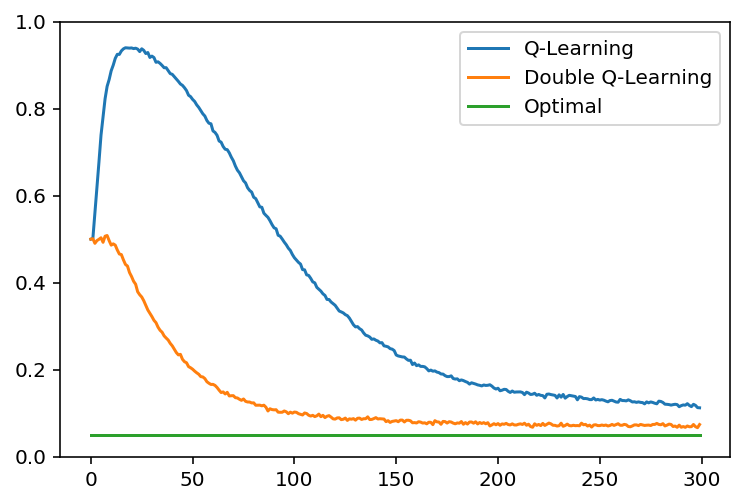

In [10]:
NUM_TRIALS = 10000 #트라이얼 횟수: 오래 걸리니 100, 1000정도 추천
NUM_EPISODES = 300 #트라이얼마다 행하는 에피소드 횟수

p1 = run_trials(NUM_TRIALS, NUM_EPISODES, QLearningAgent, Environment)
p2 = run_trials(NUM_TRIALS, NUM_EPISODES, DoubleQLearningAgent, Environment)

plt.ylim(0, 1)
plt.plot(range(NUM_EPISODES), p1)
plt.plot(range(NUM_EPISODES), p2)
plt.plot(range(NUM_EPISODES), [DoubleQLearningAgent.epsilon / 2] * NUM_EPISODES)
plt.legend(['Q-Learning', 'Double Q-Learning', 'Optimal'])
# plt.savefig('result.png')
plt.show()